In [1]:
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from collections import namedtuple
import os
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from src.utils import normalize, setup_dataset

%matplotlib inline

def convert(dictionary):
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)
torch.cuda.set_device(0)

In [2]:
############################

DATASET = 'celeba'  # cifar10, imagenet

############################

In [3]:
dtype = torch.cuda.FloatTensor

opt=({      
         'nz':128, 
         'nout':128,
         'ngf':64, 
         'ndf': 64, 
         'noise': 'sphere',
         'ngpu': 1,
         'dataset': 'cifar10',
         'image_size':32,
         'workers':0,
         'batch_size': 64,
        })

if DATASET=='cifar10':
    # default params work for cifar10
    pass
elif DATASET== 'imagenet':
    opt['dataset'] = 'imagenet'
    opt['dataroot'] = '/sdh/data/imagenet' # put here your path
elif DATASET=='celeba':
    opt.update({      
             'nz':64, 
             'dataset': 'celeba',
             'dataroot': '/sdh/data/celebA/imgs1', # put here your path
             'image_size':64, 
            })

opt['nc'] =  1 if opt['dataset'] == 'mnist' else 3
opt['netG'] = 'dcgan32px'
opt['netE'] = 'dcgan32px'
opt['netG_chp'] = ''
opt['netE_chp'] = ''
opt1 = opt
opt= convert(opt)

In [4]:
import pickle
from src.utils import *
# Load g,e
E_path = 'pretrained/%s_e.pth' % DATASET
G_path = 'pretrained/%s_g.pth' % DATASET

# E_path = 'pretrained/%s_e.pth' % DATASET
# G_path = 'pretrained/%s_g.pth' % DATASET
# Dstr = '../data/checkpoints/KL_qp_cifar10_sphereDp_my/netD_epoch_100.pth'
# Gstr = '../data/checkpoints/KL_qp_cifar10_sphereDp_my/netG_epoch_100.pth'

# E_path = '/home/dulyanov/projects/icml2017/figs_code/' + Dstr
# G_path = '/home/dulyanov/projects/icml2017/figs_code/' + Gstr


    
# netG, netD = None,None
# if True:
#     opt1['netG'] = 'dcgan32px'
#     opt1['netE'] = 'dcgan32px'
#     netG = load_G(opt)
#     netE = load_E(opt)
#     netG.main.load_state_dict(torch.load(G_path).main.state_dict())
#     netE.main.load_state_dict(torch.load(E_path).main.state_dict())
# #     netG.load_state_dict(torch.load(G_path))
# #     netE.load_state_dict(torch.load(E_path))
# else:
#     netG = torch.load(Gstr).type(torch.FloatTensor)
#     netD = torch.load(Dstr).type(torch.FloatTensor)
    
# netG = netG.type(dtype)
# netE = netE.type(dtype)
# netG.eval()
# netE.eval()

netG = torch.load(G_path).type(dtype)
netE = torch.load(E_path).type(dtype)

netG.eval()
netE.eval()

/home/dulyanov/miniconda2/lib/python2.7/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'models.base._netG_Base' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/dulyanov/miniconda2/lib/python2.7/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/dulyanov/miniconda2/lib/python2.7/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by ac

_netE_Base (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [77]:
__imp

/home/dulyanov/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dulyanov/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
attr = pd.read_csv('/home/dulyanov/list_attr_celeba.txt', delimiter=',')

In [9]:
dataloader = setup_dataset(opt, train=True, shuffle = False, drop_last=False)

In [13]:
# names = dataloader.dataloader.dataset.image_filenames
# np.save('names.npy', names)

names = np.load('names.npy')

In [71]:
# from tqdm import tqdm_notebook
# codes = []

# dataloader = setup_dataset(opt, train=True, shuffle = False, drop_last=False)
# for (input, _) in tqdm_notebook(dataloader.dataloader):
#     x = Variable(input, volatile=True)
#     ex = netE(x)
    
#     codes.append(ex.data)
# codes_ = torch.cat(codes)

codes_ = torch.load('codes.pth')
c = codes_.numpy()


a = attr.loc[[x.split('/')[-1] for x in names]]

avg_smiling = c[(a.Smiling == 1).values].mean(0)
avg_not_smiling = c[(a.Smiling == -1).values].mean(0)

# Sample

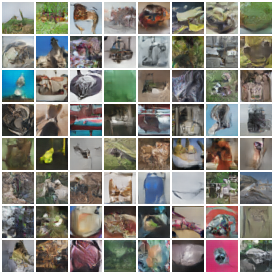

In [66]:
z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(None, z).data.cpu()

grid = torchvision.utils.make_grid(samples/2 + 0.5, pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

In [68]:
samples.max()

0.9414150714874268

In [69]:
!mkdir samples_imagenet

In [6]:
5000/256

19

In [35]:
samples.min()

-0.9978756904602051

In [70]:
for j in range(40):
    print(j)
    z = Variable(dtype(256, opt.nz, 1, 1).normal_(0, 1), volatile=True)
    z = normalize(z)
    
    samples = netG(None, z).data.cpu()/2 + 0.5

    for i in range(samples.size(0)):
        torchvision.utils.save_image(samples[i], 'samples_imagenet/%d_%d.png' % (j, i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


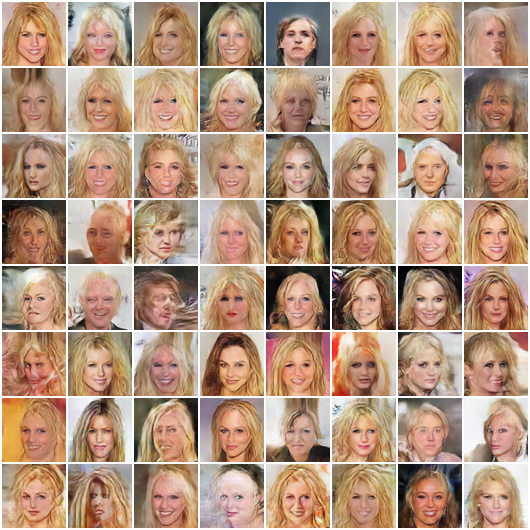

In [58]:
# z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
t = Variable(torch.from_numpy(avg_smiling- avg_not_smiling).view(1,opt.nz,1,1).expand_as(z.data))
t = normalize(t)
z1 = z + 0.4*t
z1 = normalize(z1)

samples1 = netG(None, z1).data.cpu()

grid = torchvision.utils.make_grid(samples1/2 + 0.5, pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

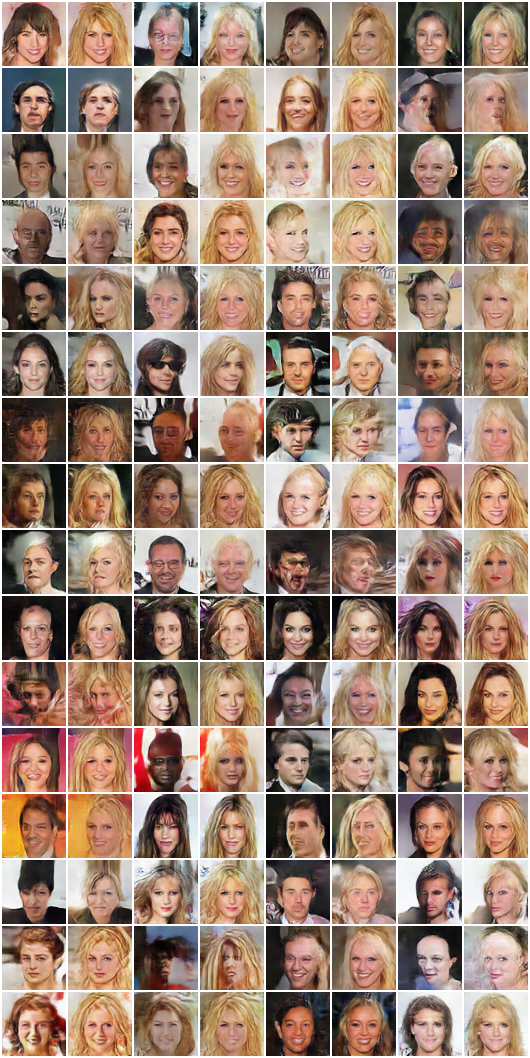

In [60]:
x = samples


t = torch.FloatTensor(x.size(0) * 2, x.size(1), x.size(2), x.size(3))
t[0::2] = samples.cpu()[:]
t[1::2] = samples1.cpu()[:]


# torch.cat([samples[::2],samples1[::2]])
# samples
grid = torchvision.utils.make_grid(t/2 + 0.5, pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

# Reconstruct

In [12]:
from PIL import Image
def get_images():

    imgs = []
    for i in range(32):
        img = np.array(Image.open(
            '/home/dulyanov/projects/icml2017.1/figs_code/celeba/%d.png' % i).convert('RGB'))

        imgs.append(img)

    imgs = np.array(imgs)
#     print imgs.shape

    return imgs.transpose(0, 3, 1, 2).astype(np.float32) / 255

origs = get_images()*2 - 1

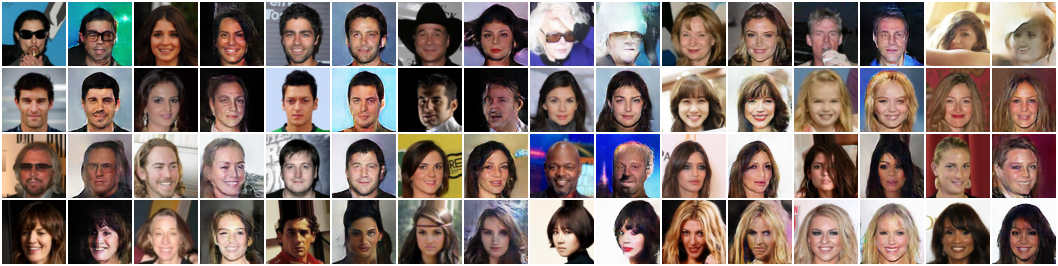

In [13]:
x = Variable(torch.FloatTensor(origs).type(dtype), volatile=True)
# x = Variable(torch.FloatTensor(origs), volatile=True)

ex = netE(x)
gex = netG(None, ex)


t = torch.FloatTensor(x.size(0) * 2, x.size(1), x.size(2), x.size(3))
t[0::2] = x.data.cpu()[:]
t[1::2] = gex.data.cpu()[:]


grid = torchvision.utils.make_grid(t/2 + 0.5, pad_value=1, nrow=16)
grid_PIL = transforms.ToPILImage()(grid)


grid_PIL

In [16]:
for i in range(32):
    torchvision.utils.save_image(gex[i,:].data/2 + 0.5, '/home/dulyanov/projects/icml2017.1/figs_code/ours_out/%d.png' %i) 
        

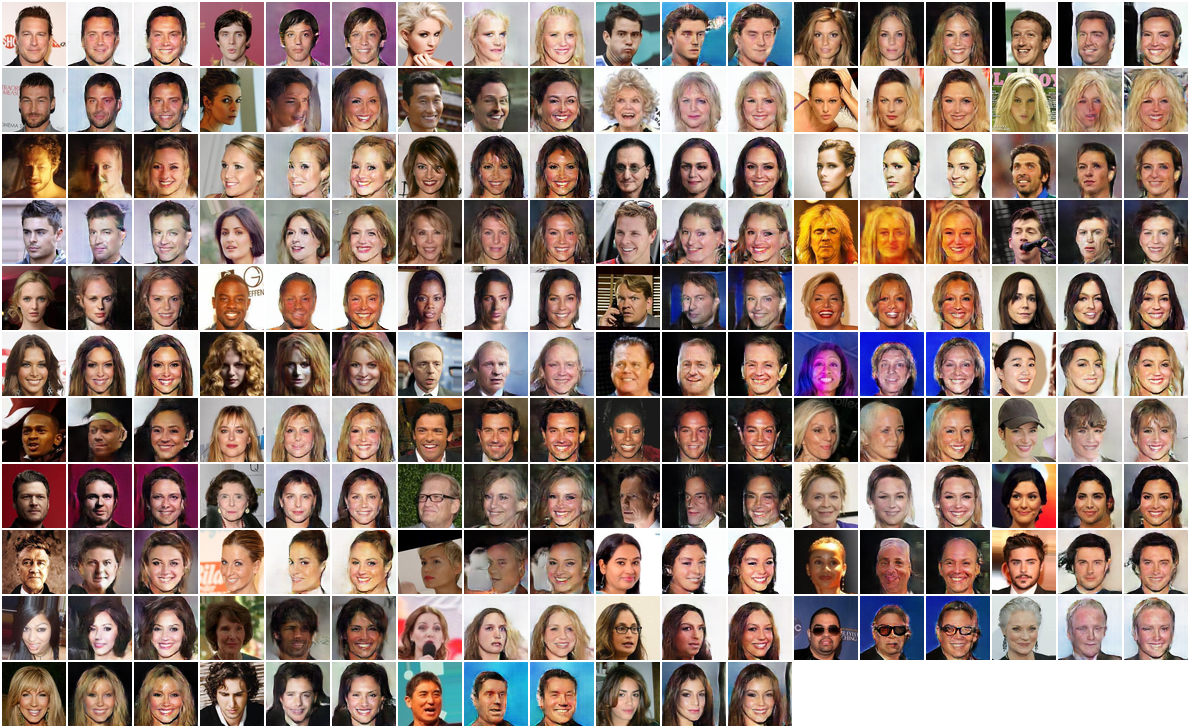

In [81]:
# x = Variable(d[0], volatile=True)

t = Variable(torch.from_numpy(avg_smiling- avg_not_smiling).view(1,opt.nz,1,1).expand_as(z.data))
t = normalize(t)
ex1 = ex + 0.5*t

# ex = netE(x)
gex1 = netG(None, ex1)


t = torch.FloatTensor(x.size(0) * 3, x.size(1), x.size(2), x.size(3))
t[0::3] = x.data.cpu()[:]
t[1::3] = gex.data.cpu()[:]
t[2::3] = gex1.data.cpu()[:]


grid = torchvision.utils.make_grid(t/2 + 0.5, pad_value=1, nrow=18)
grid_PIL = transforms.ToPILImage()(grid)


grid_PIL